In [1]:
%matplotlib inline

In [2]:
!pip3 install spacy sklearn nltk > /dev/null
!python3 -m spacy download en_core_web_sm > /dev/null

In [3]:
import itertools as itt
from zipfile import ZipFile
from matplotlib import pyplot as plt
import tqdm
from collections import Counter
import numpy as np
from sklearn import linear_model, model_selection, metrics, cluster
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy
nlp = spacy.load('en_core_web_sm')
nlp.remove_pipe('parser')
nlp.remove_pipe('ner')
nlp.add_pipe(nlp.create_pipe('sentencizer'))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yk/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# reading labels
labels_dict = dict()
with open('case_reversed.csv') as f:
    next(f)  # header
    for line in f:
        caseId, label = line.strip().split(',')
        label = int(label)
        labels_dict[caseId] = label

In [5]:
# reading cases
with ZipFile('cases.zip') as casesZip:
    cases = []
    for name in itt.islice(casesZip.namelist(), 10000):  # built in to limit data to debug
        with casesZip.open(name) as f:
            year, caseId = name[:-len('.txt')].split('_')
            label = labels_dict[caseId]
            cases.append(dict(id=caseId, label=label, text=f.read().decode('utf-8').strip(), year=int(year)))

In [6]:
# parsing with spacy
for case in tqdm.tqdm(cases):
    case['nlp'] = nlp(case['text'])

100%|██████████| 5762/5762 [17:47<00:00,  3.64it/s]


In [7]:
num_chars, num_words, num_sents = zip(*(
    (
        len(case['text']), 
        len(case['nlp']), 
        len(list(case['nlp'].sents))
    ) for case in cases))

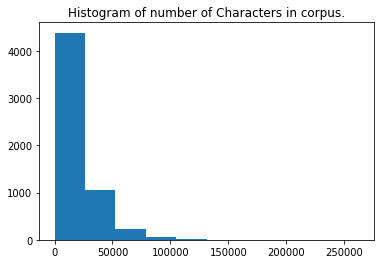

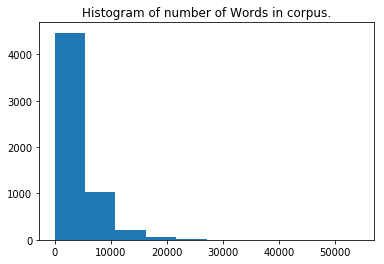

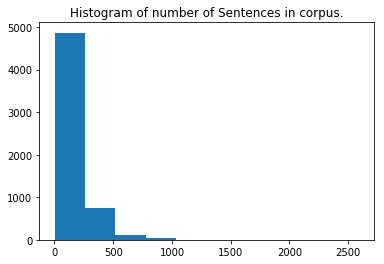

In [8]:
for name, freq in (
    ('Characters', num_chars),
    ('Words', num_words),
    ('Sentences', num_sents)
):
    plt.figure()
    plt.hist(freq)
    plt.title('Histogram of number of {} in corpus.'.format(name))
plt.show()

In [9]:
# get POS frequencies
data = []
for year, group in itt.groupby(sorted(cases, key=lambda c: c['year']), lambda c: c['year']):
    counters = [Counter(t.pos_ for t in case['nlp']) for case in group]
    data.append((year, sum(counters, Counter())))
years, counters = zip(*data)

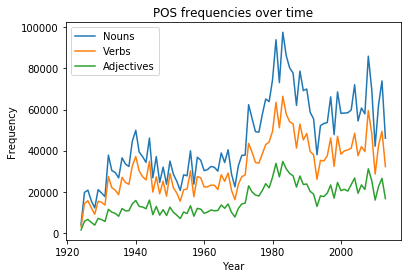

In [10]:
plt.figure()
for name, key in (
    ('Nouns', 'NOUN'),
    ('Verbs', 'VERB'),
    ('Adjectives', 'ADJ')
):
    plt.plot(years, [c[key] for c in counters], label=name)

plt.title('POS frequencies over time')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.show()

In [11]:
# removing punctuation and stop words
for case in cases:
    case['normal'] = [t for t in case['nlp'] 
                      if not (
                          t.pos_ == 'PUNCT' 
                          or t.is_stop
                          or len(t.text.strip()) == 0
                      )]

In [12]:
# parse trigrams ending in nouns
for case in cases:
    case['trigrams'] = []
    for t1, t2, t3 in zip(
        case['normal'][:-2],
        case['normal'][1:-1],
        case['normal'][2:]):
        if t3.pos_ == 'NOUN':
            case['trigrams'].append((t1.lemma, t2.lemma, t3.lemma))

# get 1000 most frequent ngrams
trigrams_voc = Counter(
    itt.chain.from_iterable(
        c['trigrams'] for c in cases
    )
).most_common(1000)

In [13]:
# create index table
trigram_to_idx = {t[0]: i for i, t in enumerate(trigrams_voc)}

In [14]:
# determine features of cases
for case in cases:
    case['features'] = [trigram_to_idx[t] 
                        for t in case['trigrams'] 
                        if t in trigram_to_idx]
            

In [15]:
# create data
data = np.zeros((len(cases), 1000))
labels = np.zeros(len(cases), np.int)
for idx, case in enumerate(cases):
    data[idx][case['features']] = 1.
    labels[idx] = case['label']

In [16]:
# make variance one
data /= np.std(data, axis=0)

In [17]:
data_train, data_test, labels_train, labels_test = model_selection.train_test_split(data, labels, test_size=0.1)

In [18]:
# create classifier
lr = linear_model.LogisticRegression(solver='liblinear')

In [19]:
# fit and predict
lr.fit(data_train, labels_train)
for name, X, Y in (
    ('Train', data_train, labels_train),
    ('Test', data_test, labels_test)
):
    pred = lr.predict(X)
    acc = metrics.accuracy_score(Y, pred)
    f1 = metrics.f1_score(Y, pred)
    print('{} Accuracy: {}'.format(name, acc))
    print('{} F1: {}'.format(name, f1))

Train Accuracy: 0.7344262295081967
Train F1: 0.8039299444681759
Test Accuracy: 0.6031195840554593
Test F1: 0.7060333761232348


In [20]:
# grid search
param_grid = {
    'penalty': ('l1', 'l2'),
    'C': np.logspace(-2, 2, 20)
}
grid = model_selection.GridSearchCV(lr, param_grid, cv=5, return_train_score=False, iid=False)
grid.fit(data_train, labels_train)

print('Best parameters: {} (Score: {})'.format(grid.best_params_, grid.best_score_))

# get the best estimator
best_lr = grid.best_estimator_

Best parameters: {'C': 0.01, 'penalty': 'l1'} (Score: 0.63182261423269)


In [21]:
# compute predictions
prob_train = best_lr.predict_proba(data_train)[:, 1]
prob_test = best_lr.predict_proba(data_test)[:, 1]

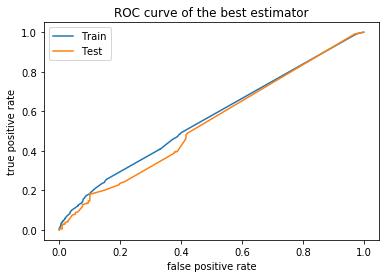

In [22]:
# compute roc curve
fpr_train, tpr_train, _ = metrics.roc_curve(labels_train, prob_train)
fpr_test, tpr_test, _ = metrics.roc_curve(labels_test, prob_test)
plt.figure()
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curve of the best estimator')
plt.legend(loc='best')
plt.show()

In [23]:
# compute auc
auc_train = metrics.roc_auc_score(labels_train, prob_train)
auc_test = metrics.roc_auc_score(labels_test, prob_test)
print('ROC AUC Train: {}'.format(auc_train))
print('ROC AUC Test: {}'.format(auc_test))

ROC AUC Train: 0.5631367642892001
ROC AUC Test: 0.5378744539213647


In [24]:
# get all sentences
sentences = np.array(list(map(str, itt.chain.from_iterable(c['nlp'].sents for c in cases))))

In [25]:
# compute sentiments
sid = SentimentIntensityAnalyzer()
scored_sents = list(sorted((sid.polarity_scores(s)['compound'], s) for s in tqdm.tqdm(sentences)))


100%|██████████| 884436/884436 [04:52<00:00, 3019.61it/s]


In [26]:
print('LOWEST SENTIMENT SENTENCES:')
for sc, s in scored_sents[:10]:
    print(s)
    print('-----')

LOWEST SENTIMENT SENTENCES:

[fn9] Moreover, the verdict slip read: We, the jury empaneled in the above entitled case, having heretofore determined that the defendant is guilty of murder in the first degree, do hereby find: AGGRAVATING CIRCUMSTANCE(S) The victim was a fireman, peace officer, or public servant concerned in official detention who was killed in the performance of his duties () The defendant paid or was paid by another person or had contracted to pay or be paid by another person or has conspired to pay or be paid by another person for the killing of the victim () The victim was being held by the defendant for ransom or reward, or as a shield or hostage () The death of the victim occurred while defendant was engaged in the hijacking of an aircraft () The victim was a prosecution witness to a murder or other felony committed by the defendant and was killed for the purpose of preventing his testimony against the defendant in any grand jury or criminal proceeding involving [**

In [27]:
print('HIGHEST SENTIMENT SENTENCES:')
for sc, s in reversed(scored_sents[-10:]):
    print(s)
    print('-----')

HIGHEST SENTIMENT SENTENCES:

At the termination of the trust, any and all accrued or undistributed net income, and any proceeds from the investment of such net income, should be deemed and treated as property owned absolutely by Virginia R. Clifford, the beneficiary, as of the time of the termination of the trust, and the remainder of the trust estate should be deemed and treated as property owned by the settlor; that the trustee should have full power and authority to do the following things: "(a) To exercise, or to appoint proxies to exercise, any and all voting powers under any certificates or shares of stock in the trust estate; (b) to retain, or to sell, exchange, mortgage, or pledge any certificates, shares of stock, securities or other items of property or any fractional interest in any of the same now or hereafter in the trust estate, whether as part of the corpus or principal thereof or as investments or proceeds and any income therefrom, upon such terms and for such consider

In [28]:
# compute tf-idf of sentences (transform only 1000, because of time and memory)
vectorizer = TfidfVectorizer()
sent_tfidf = vectorizer.fit(sentences).transform(sentences[:1000])

In [29]:
# compute cosine-sim
cossim = metrics.pairwise.cosine_similarity(sent_tfidf, dense_output=True)

In [38]:
print('DISSIMILAR SENTENCES:')
min_inds = []
for _ in range(3):
    min_ind = np.unravel_index(cossim.argmin(), cossim.shape)
    print(sentences[min_ind[0]], sentences[min_ind[1]])
    cossim[min_ind] = 1
    cossim[min_ind[::-1]] = 1
    min_inds.append(min_ind)
for i in min_inds:
    cossim[i] = 0
    cossim[i[::-1]] = 0
cossim -= np.diag(cossim.diagonal())
print('SIMILAR SENTENCES:')
for _ in range(3):
    max_ind = np.unravel_index(cossim.argmax(), cossim.shape)
    print(sentences[max_ind[0]], sentences[max_ind[1]])
    cossim[max_ind] = 0
    cossim[max_ind[::-1]] = 0

DISSIMILAR SENTENCES:
ROSE , Circuit Judge. 
This is another sugar case.
ROSE , Circuit Judge. Those concerned in the transactions out of which it arose will be referred to as the seller, the buyer, and the bank.
ROSE , Circuit Judge. 
Only the first and last of these are parties to this litigation.
SIMILAR SENTENCES:
v. Missouri Pac. 2 v. Missouri Pac.
St. Ann. St. Ann.
St. Ann. St. Ann.


In [44]:
# k-means
num_clusters = 20
km = cluster.KMeans(num_clusters)
sent_labels = km.fit(sent_tfidf).labels_
for c in range(num_clusters):
    csents = sentences[:1000][sent_labels == c][:5]
    print('Sentences from cluster {}'.format(c))
    for s in csents:
        print(s)
    print('----------')

Sentences from cluster 0
ROSE , Circuit Judge.
KENNEDY , District Judge.
v. Missouri Pac.
2 v. Missouri Pac.
JOHNSON , District Judge.
----------
Sentences from cluster 1
Those concerned in the transactions out of which it arose will be referred to as the seller, the buyer, and the bank.

The seller was plaintiff below and is defendant in error here.

Should the steamer or steamers declare against the contract fail to arrive at the port of destination for any cause, seller was to be relieved of responsibility under the contract.

It was further provided that in case there was damage to the sugars in transit to Philadelphia preventing seller from making full delivery, seller was to deliver to each purchaser of sugar aboard that steamer a proportionate part of the sound packages.

Buyer was to open within five days confirmed irrevocable letter of credit in favor of seller for the full invoice value of the 1,000 bags.
----------
Sentences from cluster 2

In the instant case the learned ju